# Applied Data Science Capstone_Project: 
# Explore the Chinese restaurant in the city of New York

For the final capstone project, I'd like to explore the Chinese restaurant in the city of New York. 

## Introduction/Business Problem

The city of New York is the most populous city and also the most densely populated major city in the United States. It is composed of five boroughs, including Brooklyn, Queens, Manhattan, the Bronx, and Staten Island. Throughout the history, New York City has been a major port of entry for immigrants into the United States, leading itself to be a large and ethnically diverse metropolis, as well as the cultural capital of the world. The Chinese population has constituted the fastest-growing nationality in New York States. In 2015, the estimated 812,410 individuals of new Chinese immigrants moved into New York City and its surrounding areas. In addition, New York City attracts approximately 12 million foreign visitors in 2017. The highest numbers of foreign visitors are from the United Kingdom, Canada, Brazil, and China. With a large number of Chinese American population and visitors from China, Chinese food becomes one of the most popular food categories in New York City. 

In this project, we are going to explore and visualize the Chinese restaurants in New York City. The following questions are concerned:
- How about the location distribution of the Chinese restaurant?
- Where should I go to enjoy the best Chinese restaurant?
- Where is a suitable location if someone wants to open a new Chinese restaurant?


## Methodology/Data Source

In order to answer the above three questions, we need the following data:
- New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset
- New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
- The locations and quality of Chinese restaurants will be obtained via the FourSquare API utilized via the Request library in Python.



## Approach

1. Collect the data of New York City from https://cocl.us/new_york_dataset, and convert the data into a dataframe after data pre-processing
1. Locate all venues and filter out all Chinese restaurant from FourSquare API. The rating, tips and like count of each Chinese restaurant will be added to the dataframe
1. Sort the data based on the rating
1. Segment, cluster and visualize the data using various Python libraries

## Analysis and Results

We need to firstly install necessary package and import libraries.

In [57]:
!conda install -c conda-forge geopy --yes 
!conda install -c conda-forge folium=0.5.0 --yes
!pip install BeautifulSoup4
!pip install lxml

print('\'Geopy\', \'Folium\', \'BeautifulSoup4\ and \'lxml\ are installed.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

'Geopy', 'Folium', 'BeautifulSoup4\ and 'lxml\ are installed.


In [58]:
# import necessary libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import seaborn as sns

import requests # library to handle requests

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

#install Beautiful Soup and requests for Web Scaping
from bs4 import BeautifulSoup

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline
print('Libraries imported.')

Libraries imported.


### Download and explore Dataset

In [59]:
# get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

url = 'https://cocl.us/new_york_dataset'
raw_data = requests.get(url).json()

# all data are present in 'features'
features = raw_data['features']

In [60]:
# transform the data into a pandas dataframe

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in features:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [61]:
# check the shape of neighborhoods dataframe
neighborhoods.shape

(306, 4)

In [62]:
neighborhoods.to_csv('neighborhoods.csv')

In [63]:
neighborhoods=pd.read_csv('neighborhoods.csv', index_col=0)

Now we can see that New York City has 306 neighborhoods. We can further analysis the neighborhoods distribution in the five boroughs.

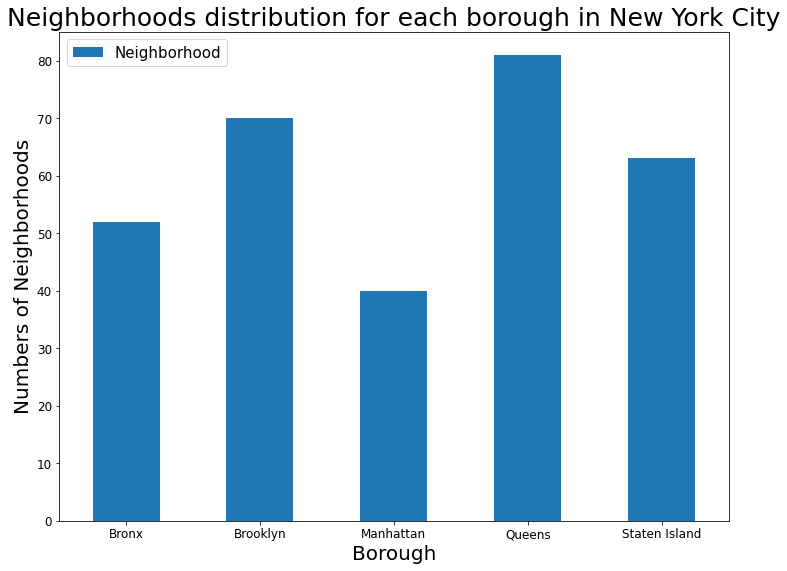

In [64]:
neighborhoods.groupby('Borough')['Neighborhood'].count().plot(kind='bar', figsize=(12,9))
plt.title('Neighborhoods distribution for each borough in New York City', fontsize=25)
plt.xlabel('Borough', fontsize=20)
plt.ylabel('Numbers of Neighborhoods',fontsize=20)
plt.xticks(rotation = 'horizontal', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)

According to the above histogram, Queens has the largest numbers of neighborhoods, while Manhattan has the least.

Now let's explore the Chinese restaurants in New York City through FourSquare API.

In [102]:
# Define the FourSquare Credentials and Version
CLIENT_ID = '' # Your client ID
CLIENT_SECRET = '' # your client_secret
VERSION = '20200819'

In [12]:
def get_venues(lat,lng):
        
    #set variables
    radius=1000
    LIMIT=50
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details, columns=column_names)
    return df


In [13]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in neighborhoods.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_restaurants=venues[venues['Category']=='Chinese Restaurant']
    print('(',count,'/',len(neighborhoods),')','Chinese Resturants in '+Neighborhood+','+Borough+':'+str(len(chinese_restaurants)))
    print(row)
    for restaurant_detail in chinese_restaurants.values.tolist():
        id, name, category=restaurant_detail
        chinese_rest_ny=chinese_rest_ny.append({'Borough':Borough,
                                              'Neighborhood':Neighborhood,
                                              'ID':id,
                                              'Name':name
                                               }, ignore_index=True)

    count+=1

( 1 / 306 ) Chinese Resturants in Wakefield,Bronx:1
['Bronx', 'Wakefield', 40.894705176609996, -73.84720052054901]
( 2 / 306 ) Chinese Resturants in Co-op City,Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.829939108124]
( 3 / 306 ) Chinese Resturants in Eastchester,Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Chinese Resturants in Fieldston,Bronx:1
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Chinese Resturants in Riverdale,Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Chinese Resturants in Kingsbridge,Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724605]
( 7 / 306 ) Chinese Resturants in Marble Hill,Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Chinese Resturants in Woodlawn,Bronx:0
['Bronx', 'Woodlawn', 40.898272612138044, -73.86731496814177]
( 9 / 306 ) Chinese Resturants in Norwood,Bronx:0
['Bronx', 'Norwoo

In [14]:
# save the information to a .csv file due to limited calls on FourSquare
chinese_rest_ny.to_csv('chinese_rest_ny_1.csv')

In [65]:
chinese_rest_ny=pd.read_csv('chinese_rest_ny_1.csv', index_col=0)

In [66]:
chinese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4edbac4e775bcc53fc0ed5f8,Hong Kong China King
1,Bronx,Fieldston,4cc4d337be40a35d390b814c,Lee's Chinese Kitchen
2,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant
3,Bronx,Pelham Parkway,4e4cf8c9bd413c4cc66da6c3,Hong Kong Restaurant
4,Bronx,City Island,4bfc652bf14fa593c1f5c9d4,City Island Chinese Resturant


In [67]:
chinese_rest_ny.tail()

,Borough,Neighborhood,ID,Name
228,Bronx,Kingsbridge Heights,566f33e7498e44c2501bda81,Panda Express
229,Brooklyn,Erasmus,4be756a4910020a1db5ad514,Cam Tak Express Restaurant
230,Queens,Hammels,4c72ad2bad69b60cb31b84b9,301 Chinese Resturant
231,Queens,Bayswater,4e4e41e8bd4101d0d7a620e0,Magic Wok
232,Staten Island,Fox Hills,4cf9aa7ad8468cfadaa9e86b,Kum Fung Kitchen


In [68]:
chinese_rest_ny.shape

(233, 4)

Now we got 233 Chinese Restaurants across New York City. We will further analysis the data to see how many Chinese restaurants there are in each borough and neighborhood and plot the results.

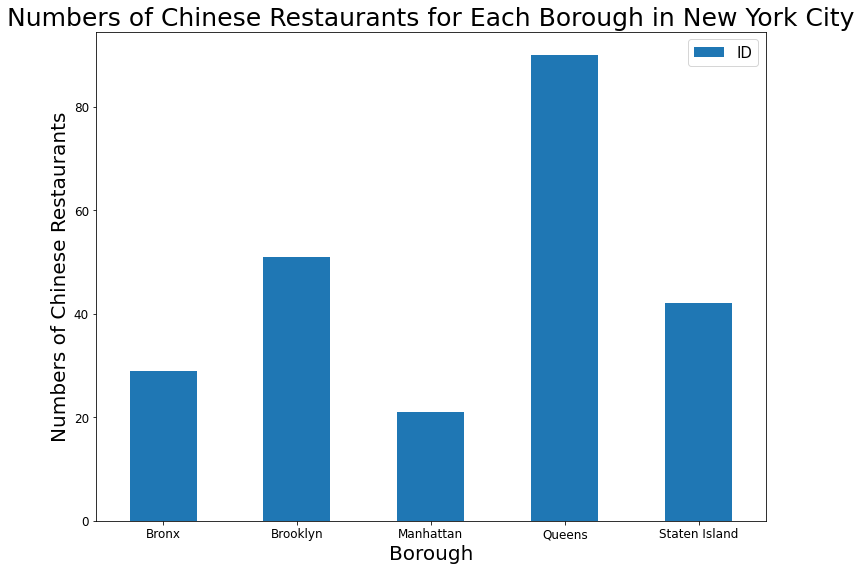

In [69]:
chinese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar', figsize=(12,9))
plt.title('Numbers of Chinese Restaurants for Each Borough in New York City', fontsize=25)
plt.xlabel('Borough', fontsize=20)
plt.ylabel('Numbers of Chinese Restaurants',fontsize=20)
plt.xticks(rotation = 'horizontal', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)

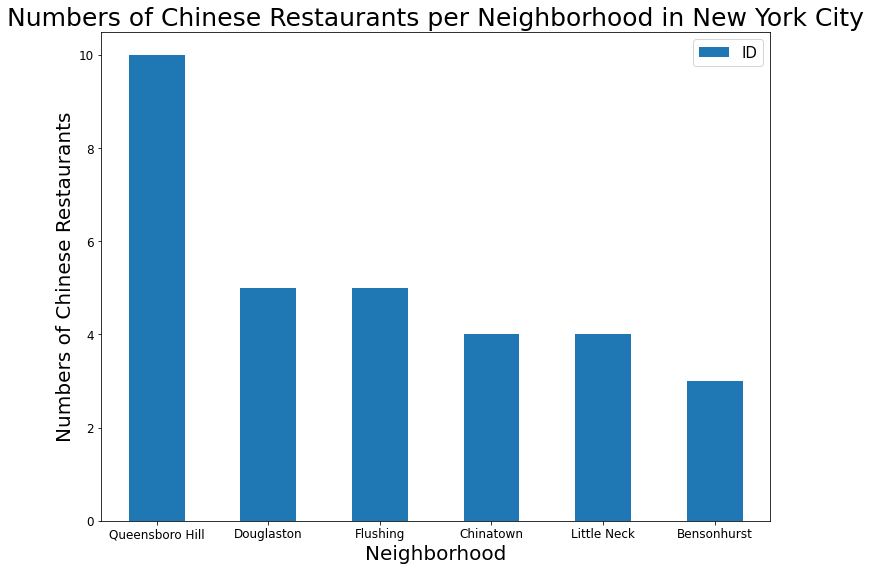

In [70]:
# the top 6 neighborhoods that have Chinese restaurants
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(6).plot(kind='bar', figsize=(12,9))
plt.title('Numbers of Chinese Restaurants per Neighborhood in New York City', fontsize=25)
plt.xlabel('Neighborhood', fontsize=20)
plt.ylabel('Numbers of Chinese Restaurants',fontsize=20)
plt.xticks(rotation = 'horizontal', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)

In [71]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Queensboro Hill']


,Borough,Neighborhood,ID,Name
142,Queens,Queensboro Hill,4ac90140f964a520f7bd20e3,Main Street Taiwanese Gourmet 北港台菜
143,Queens,Queensboro Hill,4f844c6fe4b0059705cb042c,Lake Pavilion Restaurant
144,Queens,Queensboro Hill,50e9c4b1e4b0541e6c67a2ab,Hly Chinese Cuisine (三人百姓)
145,Queens,Queensboro Hill,4c2bfb622219c928f58ca548,Fukuoka Shabu Shabu
146,Queens,Queensboro Hill,559f3c6a498e9eb732ee3027,Deng Ji Noodle House 云南过桥米线
147,Queens,Queensboro Hill,4c56000b3e2220a163eb3ea5,88 Canteen
148,Queens,Queensboro Hill,52019f6b498edfb499f84202,Ke Zhang
149,Queens,Queensboro Hill,4d93dd049892a1cd99799569,Yi Lan Halal Restaurant
150,Queens,Queensboro Hill,517d47f1e4b04f1b6e2f03f3,Good Fortune Restaurant
151,Queens,Queensboro Hill,4e44630a1f6e0a1ba5dd4e21,T&T Restaurant


In [72]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Queensboro Hill'].shape

(10, 4)

In [73]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Douglaston']


,Borough,Neighborhood,ID,Name
107,Queens,Douglaston,53794fd211d282a3cce576a2,Little Dumpling 李小籠
108,Queens,Douglaston,571ab7b2498ed52e0d5f4bca,LN1380 舍得食府
109,Queens,Douglaston,4bc25d5b4cdfc9b627109621,Northern Manor 同乐轩
110,Queens,Douglaston,5316051c11d2b2540d59332f,Best Garden Chinese Restaurant
111,Queens,Douglaston,49f3a080f964a520c36a1fe3,Dragon Express Chinese Restaurant


In [74]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Flushing']

,Borough,Neighborhood,ID,Name
89,Queens,Flushing,5747a89b498ee4b7a5106556,DunHuang Lanzhou Beef Noodle
90,Queens,Flushing,4fa3f81be4b0a34ac673bf1e,Taipei Hong 台北夯
91,Queens,Flushing,52235ea211d2fe55782d764c,Dong Yi Feng
92,Queens,Flushing,4faff7eae4b03b8055801cde,Xi'an Famous Foods
93,Queens,Flushing,4c78756397028cfaec16d8fe,New Golden Szechuan Chinese Restaurant


In [75]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Chinatown']

,Borough,Neighborhood,ID,Name
63,Manhattan,Chinatown,4db3374590a0843f295fb69b,Spicy Village
64,Manhattan,Chinatown,5894c9a15e56b417cf79e553,Xi'an Famous Foods
65,Manhattan,Chinatown,4a96bf8ff964a520ce2620e3,Wah Fung Number 1 Fast Food 華豐快餐店
66,Manhattan,Chinatown,5c965dad5455b2002c058659,Yi Ji Shi Mo Noodle Corp


In [76]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Little Neck']

,Borough,Neighborhood,ID,Name
103,Queens,Little Neck,53794fd211d282a3cce576a2,Little Dumpling 李小籠
104,Queens,Little Neck,53acac39498e3f6a67265048,Moonstone
105,Queens,Little Neck,571ab7b2498ed52e0d5f4bca,LN1380 舍得食府
106,Queens,Little Neck,4bc25d5b4cdfc9b627109621,Northern Manor 同乐轩


In [77]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Bensonhurst']

,Borough,Neighborhood,ID,Name
25,Brooklyn,Bensonhurst,4c65da95f7a80f47b6959c7a,Spicy Bampa
26,Brooklyn,Bensonhurst,574a1a53498e6a1b7cb336cb,Orchid Dynasty
27,Brooklyn,Bensonhurst,4bdcc1043904a593ba9e4f9e,New Ruans


Queens has the highest number of Chinese restaurants as a borough with the highest number of neighborhoods. Moreover, the neighborhood of Queensboro Hill located in Queens has 10 Chinese restaurants, the highest number in all neighborhoods of New York City.

In [78]:
# define a function to get venue details like like count, rating, tip counts for a given venue id.
def get_venue_details(venue_id):
      
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results=requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df=pd.DataFrame(venue_details,columns=column_names)
    return df

In [79]:
column_names=['Borough','Neighborhood','ID','Name','Likes','Rating','Tips']
chinese_rest_ny_rating=pd.DataFrame(columns=column_names)
count=1
for row in chinese_rest_ny.values.tolist():
    Borough, Neighborhood, ID, Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_ny_rating=chinese_rest_ny_rating.append({'Borough':Borough,
                                                           'Neighborhood':Neighborhood,
                                                           'ID':id,
                                                           'Name':name,
                                                           'Likes':likes,
                                                           'Rating':rating,
                                                           'Tips':tips
                                                           },ignore_index=True)
    
    count+=1
    

{'meta': {'code': 200, 'requestId': '5f434a31f26cab155cfff32d'}, 'response': {'venue': {'id': '4edbac4e775bcc53fc0ed5f8', 'name': 'Hong Kong China King', 'contact': {'phone': '7189946809', 'formattedPhone': '(718) 994-6809'}, 'location': {'address': '1213 E 233rd St', 'crossStreet': 'Baychester Avenue', 'lat': 40.88956832885742, 'lng': -73.84291076660156, 'labeledLatLngs': [{'label': 'display', 'lat': 40.88956832885742, 'lng': -73.84291076660156}], 'postalCode': '10466', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1213 E 233rd St (Baychester Avenue)', 'Bronx, NY 10466', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hong-kong-china-king/4edbac4e775bcc53fc0ed5f8', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': 

In [80]:
# save the rating data to a .csv file due to the limited call on FourSquare
chinese_rest_ny_rating.to_csv('chinese_rest_ny_rating.csv')

In [81]:
chinese_rest_ny_rating=pd.read_csv('chinese_rest_ny_rating.csv', index_col=0)

In [82]:
chinese_rest_ny_rating.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,0,0,0,0.0,0
1,Bronx,Fieldston,0,0,0,0.0,0
2,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,9,7.7,10
3,Bronx,Pelham Parkway,0,0,0,0.0,0
4,Bronx,City Island,4bfc652bf14fa593c1f5c9d4,City Island Chinese Resturant,6,6.3,4


In [83]:
chinese_rest_ny_rating.shape

(233, 7)

In [84]:
chinese_rest_ny.shape

(233, 4)

Now we have the rating information of all Chinese restaurants in New York City. 

In [85]:
# check the data types
chinese_rest_ny_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 232
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       233 non-null    object 
 1   Neighborhood  233 non-null    object 
 2   ID            233 non-null    object 
 3   Name          233 non-null    object 
 4   Likes         233 non-null    int64  
 5   Rating        233 non-null    float64
 6   Tips          233 non-null    int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 14.6+ KB


In [86]:
# convert the string values of "Likes" and "Tips" into float
chinese_rest_ny_rating['Likes']=chinese_rest_ny_rating['Likes'].astype('float64')
chinese_rest_ny_rating['Tips']=chinese_rest_ny_rating['Tips'].astype('float64')
chinese_rest_ny_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 232
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       233 non-null    object 
 1   Neighborhood  233 non-null    object 
 2   ID            233 non-null    object 
 3   Name          233 non-null    object 
 4   Likes         233 non-null    float64
 5   Rating        233 non-null    float64
 6   Tips          233 non-null    float64
dtypes: float64(3), object(4)
memory usage: 14.6+ KB


In [87]:
# understand the data
chinese_rest_ny_rating.describe()

,Likes,Rating,Tips
count,233.000000,233.000000,233.000000
mean,39.600858,5.110730,14.291845
std,141.868654,3.527236,46.337506
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,6.000000,6.800000,4.000000
75%,17.000000,7.800000,8.000000
max,1487.000000,9.000000,521.000000


In [88]:
# find the Chinese restaurant with maximum Likes
chinese_rest_ny_rating.iloc[chinese_rest_ny_rating['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1487
Rating                               8.9
Tips                                 521
Name: 74, dtype: object

In [89]:
# find the Chinese restaurant with maximum Rating
chinese_rest_ny_rating.iloc[chinese_rest_ny_rating['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood             Windsor Terrace
ID              54e39b14498e9c646b42958e
Name                East Wind Snack Shop
Likes                                139
Rating                                 9
Tips                                  50
Name: 32, dtype: object

In [90]:
# find the Chinese restaurant with maximum Tips
chinese_rest_ny_rating.iloc[chinese_rest_ny_rating['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1487
Rating                               8.9
Tips                                 521
Name: 74, dtype: object

Let's visualize the rating data based on the neighborhood and borough in NYC, respectively.

In [91]:
# visualize the neighborhood with maximum average ratings of restaurants
chinese_rest_ny_neighborhood_rating=chinese_rest_ny_rating.groupby('Neighborhood', as_index=False).mean()[['Neighborhood','Rating']]
chinese_rest_ny_neighborhood_rating.columns=['Neighborhood','Average Rating']
chinese_rest_ny_neighborhood_rating.sort_values(['Average Rating'], ascending=False).head()

,Neighborhood,Average Rating
131,South Side,9.0
85,Lower East Side,9.0
102,North Side,9.0
149,Windsor Terrace,9.0
50,Flatiron,8.9


In [92]:
# visualize the Borough with maximum average rating of restaurants
chinese_rest_ny_borough_rating=chinese_rest_ny_rating.groupby('Borough', as_index=False).mean()[['Borough','Rating']]
chinese_rest_ny_borough_rating.columns=['Borough','Average Rating']
chinese_rest_ny_borough_rating.sort_values(['Average Rating'], ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.490476
3,Queens,5.437778
1,Brooklyn,5.305882
0,Bronx,3.603448
4,Staten Island,3.523810


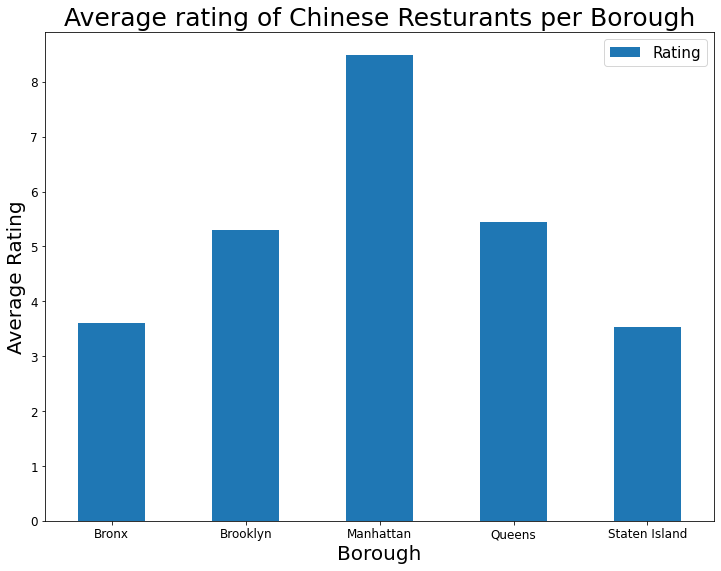

In [93]:
chinese_rest_ny_rating.groupby('Borough').mean()['Rating'].plot(kind='bar', figsize=(12,9))
plt.title('Average rating of Chinese Resturants per Borough', fontsize=25)
plt.xlabel('Borough', fontsize = 20)
plt.ylabel('Average Rating', fontsize=20)
plt.xticks(rotation = 'horizontal', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)

Further visually map the neighborhoods with an average rating that is greater than or equal to 8.0.

In [94]:
chinese_rest_ny_neighborhood_rating=chinese_rest_ny_neighborhood_rating[chinese_rest_ny_neighborhood_rating['Average Rating']>=8.0]
chinese_rest_ny_neighborhood_rating

,Neighborhood,Average Rating
4,Bay Ridge,8.30
7,Bayswater,8.00
25,Chelsea,8.90
26,Chinatown,8.75
36,Downtown,8.65
37,Dyker Heights,8.15
40,East Village,8.80
45,Elmhurst,8.25
50,Flatiron,8.90
52,Flushing,8.04


In [95]:
# Get the latitude and longitude of the restaurants in this dataset.
chinese_rest_ny_neighborhood_rating=pd.merge(chinese_rest_ny_neighborhood_rating, neighborhoods, on='Neighborhood' )

In [96]:
chinese_rest_ny_neighborhood_rating=chinese_rest_ny_neighborhood_rating[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [97]:
chinese_rest_ny_neighborhood_rating

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bay Ridge,40.625801,-74.030621,8.30
1,Queens,Bayswater,40.611322,-73.765968,8.00
2,Manhattan,Chelsea,40.744035,-74.003116,8.90
3,Staten Island,Chelsea,40.594726,-74.189560,8.90
4,Manhattan,Chinatown,40.715618,-73.994279,8.75
5,Brooklyn,Downtown,40.690844,-73.983463,8.65
6,Brooklyn,Dyker Heights,40.619219,-74.019314,8.15
7,Manhattan,East Village,40.727847,-73.982226,8.80
8,Queens,Elmhurst,40.744049,-73.881656,8.25
9,Manhattan,Flatiron,40.739673,-73.990947,8.90


Visualize the neighborhood dataset by mapping it.

In [98]:
# get the geo location of address
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude 

In [99]:
# Create map
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in chinese_rest_ny_neighborhood_rating[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [100]:
# add a new filed to dataframe for lablelling
chinese_rest_ny_neighborhood_rating['Label']=chinese_rest_ny_neighborhood_rating['Neighborhood']+', '+chinese_rest_ny_neighborhood_rating['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in chinese_rest_ny_neighborhood_rating[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

## Discussion
- New York has 306 neighborhoods distributed in 5 boroughs of Bronx, Brooklyn, Manhattan, Queens, and Staten Island. Among them, the borough of Queens has the largest number of neighborhoods, while the borough of Manhattan has the least.
- New York City has 233 Chinese restaurants in total. The borough of Queens has the largest number of Chinese restaurants among all five boroughs, while Manhattan has the least.
- Queensboro Hill (Queens), Douglaston (Queens), Flushing(Queens), Chinatown (Manhattan), Little Neck (Queens), and Bensonhurst (Brooklyn) have the most Chinese restaurants in all 306 neighborhoods accross the NYC.
- The Chinese restaurants in Manhattan has the highest average rating, even though Manhattan has the least number of Chinese restaurant.
- The neighborhood of Bay Ridge in Brooklyn, Bayswater in Queens and Chelsea in Manhattan are the neighborhoods that has the best average rating of Chinese restaurants.

## Conclusion
233 Chinese restaurants are distributed in New York City. Among the five boroughs of Bronx, Borrklyn, Manhattan, Queens, and Staten Island in NYC, Queens has the largest number of Chinese restaurants. The neighborhood of Queensboro Hill located in Queens is the neighborhood in all of NYC with the most Chinese restaurants. Although Manhattan has the leaset number of Chineses restaurants, it has the best rated Chinese restaurants on average. I will go to the neighborhood of Bay Ridge in Brooklyn, Bayswater in Queens, and Chelsea in Manhattan to enjoy the Chinese restaurant, as they are the top three neighborhoods that have the best average rating of Chinese restaurants. Moreover, Manhattan will be a preferred choice if I want to open a new Chinese restaurant. The competition with other Chinese restaurants will be easier in Manhattan than other boroughs. 
All of the above analysis relies on the accuracy and adequacy of FourSquare data. We need to incorporate data from other external databases for further more comprehensive analysis.

## Citation

[1] Wikipedia, https://en.wikipedia.org/wiki/New_York_City